In [1]:
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from bs4 import BeautifulSoup


In [2]:
# 定義投資組合的參數
# ticker = "VT" # 股票代碼
# ticker = "5880.TW" # 股票代碼
# ticker = "2330.TW" # 股票代碼
# ticker = "0050.TW" # 股票代碼
# ticker = "0056.TW" # 股票代碼
ticker = "VWRD.L" # 股票代碼
# ticker = "ACDD01" # 安聯台灣大壩基金-A累積型(台幣)
start_date = "2017-01-01" # 起始日期
end_date = "2023-04-14" # 結束日期

# investment_amount = 10_000 / 30 # 每個月的投資金額
investment_amount = 10_000 # 每個月的投資金額
purchase_day = 1 # 每個月的第N個交易日購買

In [3]:
if ticker != 'ACDD01':
    # 獲取股票歷史股價數據和股息數據
    stock = yf.Ticker(ticker)
    history = stock.history(start=start_date, end=end_date)
    history = history.reset_index()
    history['Date'] = history['Date'].apply(lambda a: a.date)

In [4]:
def get_fund_data():
    url = f'https://www.moneydj.com/funddj/bcd/tBCDNavList.djbcd?a={ticker}&B={start_date}&C={end_date}&D='
    r = requests.get(url)
    t = r.text
    date_list = t.split(' ')[0].split(',')
    net_value_list = t.split(' ')[1].split(',')
    df = pd.DataFrame({
        'Date': date_list,
        'Net Value': net_value_list
    })
    df['Date'] = df['Date'].apply(lambda s: datetime.strptime(s, '%Y%m%d'))
    df['Date'] = df['Date'].apply(lambda a: a.date())
    df['Net Value'] = df['Net Value'].apply(lambda s: float(s))
    df = df.rename(columns={'Net Value': 'Close'})
    return df
if ticker == 'ACDD01':
    history = get_fund_data()
    dividend_history = pd.DataFrame({
        'Date': [],
        'Dividends': []
    })

In [5]:
history

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2017-01-03,70.250000,70.500000,70.129997,70.199997,2663,0.0,0.0,0.0
1,2017-01-04,70.190002,70.839996,70.190002,70.839996,2655,0.0,0.0,0.0
2,2017-01-05,70.919998,71.180000,70.849998,71.080002,5903,0.0,0.0,0.0
3,2017-01-06,71.250000,71.250000,71.000000,71.199997,1365,0.0,0.0,0.0
4,2017-01-09,71.279999,71.279999,70.959999,71.169998,30166,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1581,2023-04-05,106.300003,106.370003,105.440002,105.574997,8035,0.0,0.0,0.0
1582,2023-04-06,105.790001,106.260002,105.419998,105.839996,11039,0.0,0.0,0.0
1583,2023-04-11,106.379997,106.660004,106.339996,106.485001,13996,0.0,0.0,0.0
1584,2023-04-12,106.459999,107.660004,106.300003,106.559998,42737,0.0,0.0,0.0


In [6]:
if ticker != 'ACDD01':
    dividend_history = stock.dividends
    dividend_history = dividend_history.reset_index()
    dividend_history['Date'] = dividend_history['Date'].apply(lambda a: a.date)

In [7]:
# 如果沒有股利資料，就爬蟲抓

def get_dividend_list(symbol):     
    div_url = f'https://www.moneydj.com/ETF/X/Basic/Basic0005.xdjhtm?etfid={symbol}.TW'
    r = requests.get(div_url)
    soup = BeautifulSoup(r.text, "lxml")
    table = soup.findAll("table", class_ = "datalist")[0]
    list_rows = []
    rows = table.find_all('tr')

    for row in rows:
        row_td = [i.text for i in row.find_all('td')]
        if len(row_td)>1:
            list_rows.append(np.array(row_td)[[1,2,6]])

    df = pd.DataFrame(list_rows, columns = ['ex_div_date','pay_date','div_amount'] )
    df['symbol_id'] = [symbol] * len(df)
    return df

if ticker.split('.')[-1] == 'TW' and dividend_history.empty:
    symbol = ticker.split('.')[0]
    dividend_history = get_dividend_list(symbol)
    dividend_history['Date'] = dividend_history['pay_date']
    dividend_history['Date'] = dividend_history['Date'].apply(lambda s: datetime.strptime(s, '%Y/%m/%d'))
    dividend_history['Date'] = dividend_history['Date'].apply(lambda a: a.date())
    dividend_history['Dividends'] = dividend_history['div_amount']
    dividend_history['Dividends'] = dividend_history['Dividends'].apply(lambda s: float(s))
    dividend_history = dividend_history.drop(columns = ['ex_div_date', 'pay_date', 'div_amount', 'symbol_id'])

In [8]:
if ticker == 'VWRD.L' and dividend_history.empty:
    dividend_history = pd.read_excel('VWRD(dividends).xlsx')
    dividend_history = dividend_history.drop(list(range(6)))
    dividend_history = dividend_history.drop(list(dividend_history.index[-2:]))
    dividend_history['Date'] = dividend_history['Unnamed: 3']
    dividend_history['Dividends'] = dividend_history['Unnamed: 6']
    dividend_history = dividend_history.drop(columns = dividend_history.columns.to_numpy()[:-2])
    dividend_history = dividend_history.reset_index(drop=True)
    dividend_history['Date'] = dividend_history['Date'].apply(lambda s: datetime.strptime(s, '%d %b %Y'))
    dividend_history['Date'] = dividend_history['Date'].apply(lambda a: a.date())
    dividend_history['Dividends'] = dividend_history['Dividends'].apply(lambda s: float(s[1:]))

In [9]:
dividend_history


,Date,Dividends
0,2023-03-29,0.409169
1,2022-12-28,0.378498
2,2022-09-28,0.495607
3,2022-06-29,0.838460
4,2022-03-30,0.327370
5,2021-12-29,0.462223
6,2021-09-29,0.451967
7,2021-06-30,0.581220
8,2021-03-31,0.338011
9,2020-12-30,0.312822


In [10]:
# 交易紀錄
trade_record_dict = {
    'date': [],
    'stock_value': [],
    'stock_count': [],
    'stock_total_cost': [],
}

# 每月 purchase_day 進行購買
loop_start_dt = history.head(1)['Date'].values[0].replace(day=1)
loop_end_dt = history.tail(1)['Date'].values[0].replace(day=1)
loop_current_dt = loop_start_dt
while loop_current_dt <= loop_end_dt:
    month_start_dt = loop_current_dt.replace(day=1)
    month_end_dt = month_start_dt + relativedelta(months = 1, days = -1)
    # print(month_start_dt, month_end_dt)

    loop_current_df = history[(history['Date'] >= month_start_dt) & (history['Date'] <= month_end_dt)]
    purchase_df = loop_current_df.iloc[purchase_day - 1]
    # print(purchase_df)

    trade_date = purchase_df['Date']
    trade_stock_value = purchase_df['Close']
    trade_stock_count = np.floor(investment_amount / trade_stock_value)
    trade_stock_total_cost = trade_stock_value * trade_stock_count

    trade_record_dict['date'].append(trade_date)
    trade_record_dict['stock_value'].append(trade_stock_value)
    trade_record_dict['stock_count'].append(trade_stock_count)
    trade_record_dict['stock_total_cost'].append(trade_stock_total_cost)

    loop_current_dt = loop_current_dt + relativedelta(months = 1)
trade_record_df = pd.DataFrame(trade_record_dict)


In [11]:
# trade_record_df

In [12]:
# 現值計算
value_record_dict = {
    'date': [],
    'accumulate_stock_count': [],
    'total_cost': [],
    'total_cost_with_dividend': [],
    'total_value': [],
    'profit_rate': [],
    'profit_rate_with_dividend': [],
    'market_price': [],
}

is_first_record = True
for index, row in history.iterrows():
    trade_info_df = trade_record_df[trade_record_df['date'] == row['Date']]
    dividend_info_df = dividend_history[dividend_history['Date'] == row['Date']]
    is_trade_day = not trade_info_df.empty
    is_dividend_day = not dividend_info_df.empty

    if is_trade_day:
        trade_stock_value = trade_info_df['stock_value'].values[0]
        trade_stock_count = trade_info_df['stock_count'].values[0]
        trade_stock_total_cost = trade_info_df['stock_total_cost'].values[0]
    else:
        trade_stock_value = 0
        trade_stock_count = 0
        trade_stock_total_cost = 0

    if is_first_record:
        last_accumulate_stock_count = 0
        last_total_cost = 0
        last_total_cost_with_dividend = 0
        last_total_value = 0
    else:
        last_accumulate_stock_count = value_record_dict['accumulate_stock_count'][-1]
        last_total_cost = value_record_dict['total_cost'][-1]
        last_total_cost_with_dividend = value_record_dict['total_cost_with_dividend'][-1]
        last_total_value = value_record_dict['total_value'][-1]

    record_date = row['Date']
    accumulate_stock_count = last_accumulate_stock_count + trade_stock_count
    total_cost = last_total_cost + trade_stock_total_cost
    total_cost_with_dividend = last_total_cost_with_dividend + trade_stock_total_cost
    total_value = accumulate_stock_count * row['Close']
    market_price = row['Close']
    profit_rate = ((total_value - total_cost) / total_cost) if ((total_value != 0) and (total_value != 0)) else 0

    if is_dividend_day:
        dividend = dividend_info_df['Dividends'].values[0]
        income = accumulate_stock_count * dividend
        total_cost_with_dividend = total_cost_with_dividend - income

    profit_rate_with_dividend = ((total_value - total_cost_with_dividend) / total_cost_with_dividend) if ((total_value != 0) and (total_value != 0)) else 0

    value_record_dict['date'].append(record_date)
    value_record_dict['accumulate_stock_count'].append(accumulate_stock_count)
    value_record_dict['total_cost'].append(total_cost)
    value_record_dict['total_cost_with_dividend'].append(total_cost_with_dividend)
    value_record_dict['total_value'].append(total_value)
    value_record_dict['profit_rate'].append(profit_rate)
    value_record_dict['profit_rate_with_dividend'].append(profit_rate_with_dividend)
    value_record_dict['market_price'].append(market_price)
    is_first_record = False
value_record_df = pd.DataFrame(value_record_dict)
value_record_df

,date,accumulate_stock_count,total_cost,total_cost_with_dividend,total_value,profit_rate,profit_rate_with_dividend,market_price
0,2017-01-03,142.0,9968.399567,9968.399567,9968.399567,0.000000,0.000000,70.199997
1,2017-01-04,142.0,9968.399567,9968.399567,10059.279480,0.009117,0.009117,70.839996
2,2017-01-05,142.0,9968.399567,9968.399567,10093.360260,0.012536,0.012536,71.080002
3,2017-01-06,142.0,9968.399567,9968.399567,10110.399567,0.014245,0.014245,71.199997
4,2017-01-09,142.0,9968.399567,9968.399567,10106.139740,0.013818,0.013818,71.169998
...,...,...,...,...,...,...,...,...
1581,2023-04-05,8271.0,756675.768364,705276.339862,873210.799759,0.154009,0.238112,105.574997
1582,2023-04-06,8271.0,756675.768364,705276.339862,875402.609711,0.156906,0.241219,105.839996
1583,2023-04-11,8271.0,756675.768364,705276.339862,880737.440048,0.163956,0.248783,106.485001
1584,2023-04-12,8271.0,756675.768364,705276.339862,881357.739807,0.164776,0.249663,106.559998


In [13]:
final_profit_rate = value_record_df['profit_rate'].values[-1]
final_profit_rate_with_dividend = value_record_df['profit_rate_with_dividend'].values[-1]
print(ticker)
print(f"{start_date}-{end_date}")
print(f"final_profit_rate: {np.round(final_profit_rate * 100, 2)}%")
print(f"final_profit_rate_with_dividend: {np.round(final_profit_rate_with_dividend * 100, 2)}%")

VWRD.L
2017-01-01-2023-04-14
final_profit_rate: 17.21%
final_profit_rate_with_dividend: 25.75%


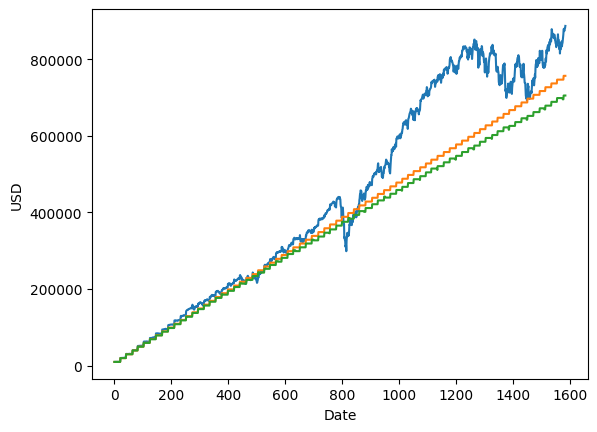

In [14]:
# 繪製股票價值和股息收入的折線圖
fig, ax = plt.subplots()
# ax.plot(portfolio_value, label="Stock Value")
# ax.plot(monthly_dividend_income.cumsum(), label="Dividend Income")
# ax.plot(portfolio_value + monthly_dividend_income.cumsum(), label="Total Portfolio Value")
ax.plot(value_record_df["total_value"], label="total_value")
ax.plot(value_record_df["total_cost"], label="total_cost")
ax.plot(value_record_df["total_cost_with_dividend"], label="total_cost_with_dividend")
# ax.plot(history["Close"], label="Close")
# ax.legend(loc="upper left")
ax.set_xlabel("Date")
ax.set_ylabel("USD")

plt.show()

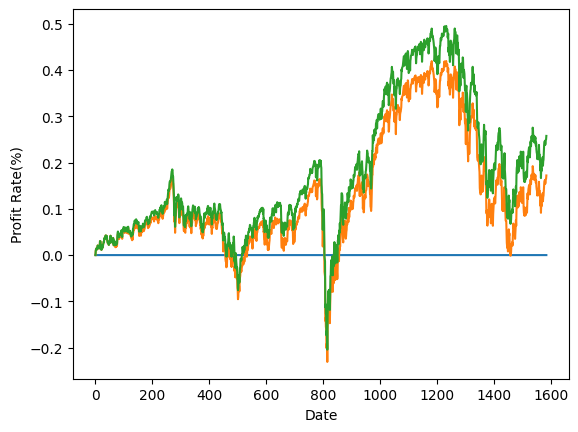

In [15]:
# 繪製股票價值和股息收入的折線圖
fig, ax = plt.subplots()
ax.plot([ 0 for _ in range(value_record_df.index.size)], label="profit_rate")
ax.plot(value_record_df["profit_rate"], label="profit_rate")
ax.plot(value_record_df["profit_rate_with_dividend"], label="profit_rate_with_out")
ax.set_xlabel("Date")
ax.set_ylabel("Profit Rate(%)")

plt.show()

In [16]:
trade_record_df.to_csv('trade_record_df.csv')
value_record_df.to_csv('value_record_df.csv')